# Quantum differentiable programming and QML intro with Pennylane

This notebook presentation is part of my lecture material for the QUARMEN master (QUAntum Research Master Education Network): a two-year international master’s programme in physics, specialized in Quantum Science and Technology. It aims at training students in key concepts and technologies for quantum devices and information. 

This lecture contains a general introduction to parameterized quantum circuits, calculation of gradients and the Pennylane software platform.

**Michele Grossi**, Coordinator of Quantum Computing and Algorithm Competence Center @ CERN \
Last updated: 03 apr 24

## Preliminary theory

### What's a quantum algorithm?

Quantum algorithms can in general be described as a specific unitary transformations 
$$U:\mathcal{H} \to \mathcal{H}$$ 
acting on a quantum register of $q$ qubits, i.e. $\mathcal{H} = (\mathbb {C} ^2)^{\otimes q}$.
After performing $U$, the solution needs to be extracted via *basis state measurement*.

Many of the algorithms described up to now rely on *precisely defining* $U$ in terms of certain set of  **fixed, elementary operations**. To give an example, the *Quantum Fourier Transform* (QFT), which is defined as

$$|n\rangle \to \frac{1}{2^q}\sum_i e^{2\pi inm/2^q}|m\rangle \;\;\text{where}\;\; 0 \leq m,n \leq 2^q$$

relies on the appropriate composition of Hadamard gates ($H$), control phases ($cR_k$) and swap gates.

<img src="https://www.researchgate.net/publication/364442891/figure/fig1/AS:11431281091064985@1666286943919/A-4-qubit-example-of-the-QFT-circuit-ie-Fn-with-n-4-consisting-of-two-parts-Qn-and.png" />

At the end, the quantum system is in a state whose computational basis amplitudes are precisely the *Discrete Fourier Transform* (DFT) of the amplitudes of the initial states, and this happens *from the begininnig*, i.e. already at the first circuit execution.

### A different (variational) perspective

A different approach is that of *Parameterized Quantum Circuits* (PQC). Here the *general structure* is defined, which is generally composed of independent **parameterized rotations** and **fixed entangling gates**, but **not** the numerical value of the parameters.

*Variational Quantum Algorithms* (VQA) or PQC are hybrid algorithm that use a classical optimizer to train a parameterized quantum circuit to approximate solutions for a given problem. You will find this family of architectures for a lot of application in different fields like: Chemistry, Physics, Finance, Machine Learning and more.

VQA typically need fewer gates and qubits. In turn, they are more resistant to noise and are well suited to handle near-term quantum computer constraints.
VQA's are typically iterative. Each iteration involves both quantum and classical processing. 

Output (a measurement) from one iteration is sent to the classical optimizer which generates input (a parameter) for the next iteration:

<div>
<img src="qva_loop.png" width="600" align="left"/>
</div>



More specifically, we will have:

* **Parameterized rotations**: A parameterized rotation is a gate which depends on a parameter $\theta \in [-\pi,\pi]$ and have the from $R_G(\theta) = e^{i \theta G}$, where $G=G^\dagger$ is the *generator* of the rotation. In general it can act on any number of qubit. Common examples include $R_\sigma(\theta)$, where $\sigma = X,Y$ or $Z$ is a single-qubit Pauli matrix.

* **Entangling gates**: An entangling gate is a fixed, non-separable unitary transformation $W$ that has the purpose of introducing interactions between qubits. Common examples include CNOT, SWAP and CPhase gates. 

Both these types of gate are usually composed in a layered fashion, e.g. $U(\theta) = \prod_{l=1}^L \left[\bigotimes_k R_{G_k}(\theta_{kl})\right] W_l$. In quantum computing jargon, these type of circuits are called *ansatz*.

Example:

<div>
<img src="4qubits-ansatz.png" width="600" align="left" alt="Approximate 2-design ansatz (4 qubits)"/>
</div>



Here, the parameters are chosen *randomly*, which means that at the first execution of the circuit, we do not have the solution to our problem yet, but we have to first find the correct parameters, and that's done by optimization of a given **cost function**.

If this sounds like it's very similar to machine learning, it's because it is!

### Cost functions and gradients

It is very common in quantum computing to use *expectation values* of observables as cost functions. 

Take the example of *ground state* energy estimation: given a certain Hamiltonian $H$, the task is to find the lowest eigenvalue. 
This can be shown to be equivalent to minimizing the expectation value 

$$E_\theta = \langle \psi_\theta |H | \psi_\theta\rangle  \;\;\; \text{with} \;\;\; |\psi_\theta \rangle = U(\theta)|\psi_0 \rangle $$

which can be done with quantum computing using a PQC and optimizing its parameters.

**Q: Given a certain ansatz, how to optimize the parameters?**

The most popular answer is to use **gradient-based** optimization schemes, which include Gradient Descent, Adam, and so on. This requires the non trivial ability to compute *gradients of quantum circuits*. In the literature, many techinques have been developed to solve this task. Among others we have:

* **Finite difference methods**: These are versatile techniques that come from calculus and apply to general functions (not only quantum circuits), but suffer from truncation errors and are not always accurate.

* **Parameter-shif rules**: These are the most commonly used techniques, that exploit the structure of $R_{G_k}(\theta)$ rotations to estimate *exact* gradients. However, this requires evaluation of 2 distinct circuits per parameter.

* **Hadamard test methods**: These type of techniques employ Hadamard tests to compute gradients. This is also exact and requires evaluation of only 1 circuit, but needs an *ancillary* qubit to be performed.

### Why Pennylane?

While these methods are great news for quantum computing practitioners, the computational cost of performing them is considerable, especially when handling a large number of parameters, since it requires running order $\sim O(p)$ circuits for each step, where $p$ is the number of parameters.

The problem becomes even worse when the circuits need to be *simulated classically*. In fact, very powerful frameworks such as Qiksit struggle with simulation of variational methods precisely for this reason.

**Q: But wait, what about classical models, don't they have the same issue?**

Of course, handling large models is always challenging, but classically there exist several methods that are very efficient and highly optimized, that go under the name of *automatic differentiation*. Pennylane's core feature is the ability to compute gradients of *simulated* parameterized quantum circuits in a way that is compatible with such techniques (e.g. *backpropagation*). Pennylane thus extends the automatic differentiation algorithms common in optimization and machine learning to include quantum and hybrid computations.

## Hands-on with Pennylane

In order to be able to use the great features Pennylane offers, one needs to understand how this new software platform works, and how to take the best from it. The most valuable source of information is of course the official API guide (https://docs.pennylane.ai/en/stable/code/qml.html), which contains documentation, tutorials and more.

In this lecture, we'll go through the main concepts, necessary to succesfully build and optimize a simple variational circuit. In particular we will learn about:

* quantum functions (i.e. circuits)
* observables
* devices and quantum nodes
* optimization


#### First steps

The first step is to install and import the pennylane package. The standard import is `qml`.

Since it will be useful to use numpy primitives and functions throught the tutorial, we will import numpy as well. 

Note however that is **crucial** to import numpy directly *from* pennylane. This is important to make sure that automatic differentiation works properly.

In [1]:
# Install Pennylane
#!pip install pennylane

# Import it
import pennylane as qml
from pennylane import numpy as np

#### Circuits vs quantum functions

In most quantum SDKs there are dedicated primitives that implement *Quantum circuits*. You may recall that indeed, this was the case for IBM's Qiskit, where quantum algorithms are realized as specific circuit objects:

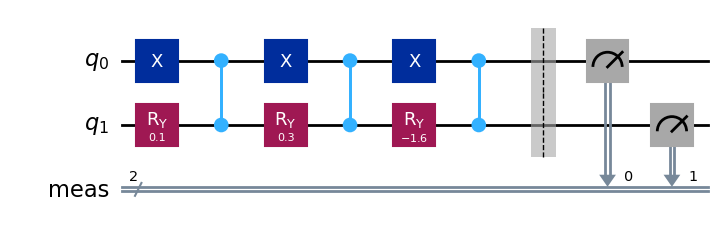

In [2]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator

#import numpy as np
thetas = np.array([0.1, 0.3, -1.6])

qiskit_circ = QuantumCircuit(2)

for t in thetas:
    qiskit_circ.x(0)
    qiskit_circ.ry(t.item(), 1)
    qiskit_circ.cz(0, 1)

qiskit_circ.measure_all()

qiskit_circ.draw("mpl")

While this approach is straight-forward to understand, makes handling parameterizations more cumbersome than really needed. What if I want to change the numerical value of $\theta$? This would either require the creation of a new circuit, or usage of more complicated abstractions, which can make our code hard to develop.  

A more natural approach for this specific use-case is to implement circuits as special kinds of **functions**, which are called quantum functions. In particular, each parameterized circuit $U(\cdot)$ is represented by a function the acts on parameter space $\Theta = [-\pi,\pi]^{p}$ and returns the circuit output, which in general is a collection of expectation values of observables $\{O_i\}_{i=1}^n$.

$$f_{U, \psi_0} : \Theta \to \mathbb {R}^n$$
$$ \theta \in \Theta \to \left[\langle \psi_0 |U^\dagger (\theta) O_1 U(\theta)|\psi_0\rangle, ... , \langle \psi_0 |U^\dagger (\theta) O_n U(\theta)|\psi_0\rangle\right] \in \mathbb {R}^n$$

This framework can be generalized to include also other types of circuit outputs, for instance computational basis measurements, or the quantum statevector itself (for simulations). In pennylane, quantum functions are implemented simply as Python functions, and evaluation of quantum functions are linked to the estimation of the circuit output specified during the definition.

Writing a quantum function is as simple as this:

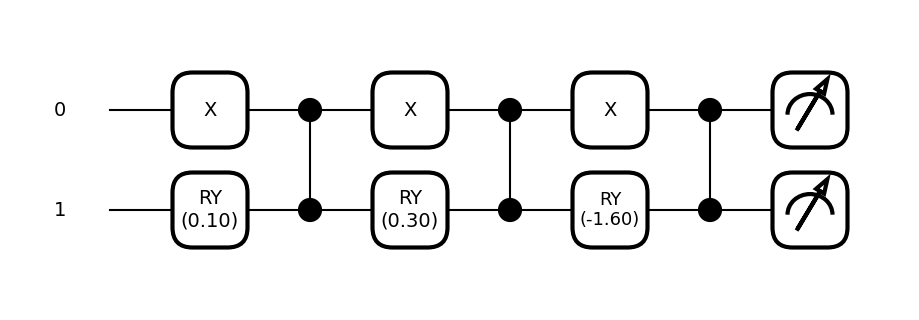

In [3]:
# The parameters of the circuit are specified as the input of the function
def circ_fn(theta):

    #By default, the initial state is |0>, just as in Qiskit

    # Gates, operations, or even other quantum functions called here will be part of circ
    # Cycles and other control flow structures are allowed, as long as they do not depend 
    # on the value of the parameters
    for t in theta:
        qml.PauliX(0)
        qml.RY(t, 1)
        qml.CZ([0,1])

    # The output type is defined with the return statement. In this case computational basis measurement is specified.
    return qml.probs()

_ = qml.draw_mpl(circ_fn, decimals=2)(theta_value)

In pennylane, quantum functions are always *differentiable*, and gradients of quantum functions can be computed both by automatic differentiation or fully quantum methods. Pennylane offers a wide variety of gates, which you can discover at https://docs.pennylane.ai/en/stable/code/qml.html#classes

#### E.1

Create and display a quantum fuction for an ansatz that includes at least a CNOT, two Z rotations and one hadamard gate, and return the marginal probabilities for each qubit.

(*Hint*: The marginal proability of a qubit can be obtain by specifying it to `qml.probs`, i.e. `qml.probs(0)` represents the marginal probability of the zeroth qubit)

#### Observables

In quantum theory, an observable is defined as an operator $O=O^\dagger$ acting on the system's Hilbert space $\mathcal{H}$. Due to the exponential dimension of $\mathcal{H}$ ($\text{dim}(\mathcal{H})=2^q$), describing $O$ is in general quite demanding. 

However, for simple enough observables, there exist very compact descriptions that can be used to define it:

* **Pauli decomposition**: It is common to define observables as linear combination of tensor produts of Pauli operators $\sigma_k$ acting on single qubits. This is especially true for Hamiltonians, that often take the form $$ H = \sum_i c_i P_i \;\;\; \text{where} \;\;\;\; P_i = \bigotimes_k \sigma^{(k)}_{i_k}$$
(In fact, every operator acting on a quantum register can  be decomposed in this way, but this strategy can incurr in exponential number of terms to keep track.)

* **Hermitian matrix**: Given a basis, each observable is represented by a Hermitian matrix, which fully characterizes $O$. However this type of description is suited only for small sistems, i.e. few qubits.

Pennylane allows to use both descriptions to characterize an observable. As an example, let's  implement
$$O = 1.7 X^{(0)}\otimes Y^{(1)} - 0.2 Z^{(0)}\otimes Z^{(1)}$$

In [4]:
# Pauli decomposition

# First we need to define the list of coefficients of the linear combination
cs = [1.7, -0.2]

# Then we need to implement the pauli strings
# @ indicates the tensor products
os = [qml.PauliX(0)@qml.PauliY(1), qml.PauliZ(0)@qml.PauliZ(1)]

O_ham = qml.Hamiltonian(cs, os)

# Hermitian matrix

O_mat = [[0.2,0,0,-1.7j],
         [0,-0.2,1.7j,0],
         [0,-1.7j,-0.2,0],
         [1.7j,0,0,0.2]]

O_her = qml.Hermitian(O_mat, wires=(0,1)) #Note: qubirs in Pennylane are called "quantum wires"

Both of them can be used as the output of a quantum function, which means that the information extracted from running the circuit, will be automatically used to compute the expectation values of those observable!

In [5]:
def obs_circ_fn(theta):

    for t in theta:
        qml.PauliX(0)
        qml.RY(t, 1)
        qml.CZ([0,1])
        
    return qml.expval(O_ham)

#### E.2
Write a function that, for any given number of qubits $W$ (quantum wires), outputs the observable $O=\bigotimes_{k=0}^{W-1} \sigma_Z^{(k)}$.

#### Devices and Quantum Nodes

Quantum functions alone, just as quantum circuits, are only an abstract description of the quantum algorithm, and are not enough to acutally perform computations. For that, we need *devices*. In pennylane, a device represents an entity able to execute quantum functions, be it a simulator or a real quantum device.

Thanks to the large amout of interfaces and plugins that this environment provides (https://pennylane.ai/plugins/) code written in pennylane can run almost on all quantum simulator (ideal, noisy, tensor-network based etc..) and even real devices (including IBM public machines!). Of course, each device has its own peculiarity and must be configured with care. 

Today we'll focus on the simplest one, i.e. `deafult.qubit`.

In [6]:
# Each device is created by calling qml.device, and specifying its device name, toghether with all required properties

dev = qml.device("default.qubit", wires=2, shots=None) # If no shots are specified, the simulation will be exact 

In order to run, the device and the quantum function must be joined to form a so called "Quantum Node" or "QNode". QNodes are the most important objects in pennylane, since they are responsible of handling differentiation of quantum functions.

In fact, when creating a QNode we are able to specify (among others) two key components in the simulation of PQCs:
* **Interface**, i.e. the classical software used to automatically differentiate simulated quantum functions (e.g. autograd, jax, pytorch, ecc..)
* **Method**, i.e. the algorithm to perform the differentiation itself. These include classical methods such as *backpropagation*, but also purely quantum ones (that would run also on real devices) such as *parameter shift rule*.

In [7]:
theta_value = np.array([0.1, 0.3, -1.6], requires_grad=True)
# In this case, we use autograd with backpropagation. If not provided, both interface and differentiation method 
# will be chosen automatically
obs_qnode = qml.QNode(obs_circ_fn, dev, interface="autograd", diff_method="backprop")

# Finally execute the function
obs_qnode(theta_value)

tensor(0.03399343, requires_grad=True)

Once we have the qnode, we can easily and quickly compute parameter gradients

In [8]:
theta_value

tensor([ 0.1,  0.3, -1.6], requires_grad=True)

In [9]:
# The qml.grad utility returns a function that lets us access the gradients
gradient = qml.grad(obs_qnode)

gradient(theta_value)

array([-0.19708995,  0.19708995,  0.19708995])

Since the concept of qnode and quantum function are so close to each other, and often one needs to create both at the same time, Pennylane offers a quick way of doing so, using the `qml.qnode` *decorator*.

In [ ]:
@qml.qnode(dev, interface="autograd", diff_method="backprop")
def decorated_qfun(theta):

    for t in theta:
        qml.PauliX(0)
        qml.RY(t, 1)
        qml.CZ([0,1])
        
    return qml.expval(O_ham)

decorated_qfun(theta_value)

#### Optimization

Almost everything is ready for optimizing our first PQC, we are only left with the choice of the optimizer. Pennylane offers many optimizers (https://docs.pennylane.ai/en/stable/introduction/interfaces.html) which can be used to optimize any quantum node. 

Moreover, thanks to the automatic differentiation capabilities, it supports optimizing also *functions* of qnodes.

In [ ]:
# Simple optimization loop

n_iter = 40    # Number of steps in the optimization
stepsize = 0.2 # Stepsize

opt = qml.GradientDescentOptimizer(stepsize)

# Initial parameters
theta = 2*np.pi*np.random.random(3)

history = []
for it in range(n_iter):

    # Apply a single optimization step. Grandient calculation is hidden here!
    theta, c = opt.step_and_cost(decorated_qfun, theta)
    history.append(c)
    
    if not it%5: print(f"Iteration: {it}\t Cost: {c}")

In [ ]:
import matplotlib.pyplot as plt

plt.title("Optimization profile")
plt.xlabel("Iterations")
plt.ylabel("Cost Function")

plt.plot(history, "-o")
plt.show()

# Quantum Gradients with BackPropagation

Any quantum device, whether a hardware device or a simulator can be trained using the **parameter-shift rule**

-----
-----

### Parameter-shift rule

The output of a variational circuit (i.e the expectation of an observable) can be written as **quantum function** $f(\theta)$ parameterized by $\theta = \theta_1 , \theta_2...$

The partial derivative of $f(\theta)$ can in many cases be expressed as a linear combination of other quantum functions. Importantly, these other quantum functions typically use the same circuit, differing only in the shift of the argument. This means that partial derivatives of a variational circuit can be computed by using the same variational circuit architecture.

Recipes of how to get partial derivatives by evaluated parameter-shifted instances of a variational circuit are called parameter-shift rules, and have been first introduced to quantum machine learning in [Mitarai et al. (2018)](https://arxiv.org/abs/1803.00745), and extended in [Schuld et al. (2018)](https://arxiv.org/abs/1811.11184).



<img src="https://pennylane.ai/static/f3aa82b497cd5cad346bca8bb8f783f1/6244b/gradients.png" />

Making a rough analogy to classically computable functions, this is similar to how the derivative of the function $f(x) = \sin(x)$ is identical to $\frac{1}{2} \sin(x +\frac{\pi}{2}) - \frac{1}{2} \sin(x - \frac{\pi}{2})$.

So the same underlying algorithm can be reused to compute both $\sin(x)$ and its derivative by evaluating at $x \pm \frac{\pi}{2}$. This inituition holds for many quantum functions of interest :  

*the same circuit can be used to compute both the quantum function and the gradient of the quantum function.*

## A more technical explaination

Quantum Circuits are specified by sequence of gates. The unitary transformation carried out by the circuit thus be broken down into a product of unitaries:

$$U(x; \theta) = U_N(\theta_{N}) U_{N-1}(\theta_{N-1}) \cdots U_i(\theta_i) \cdots U_1(\theta_1) U_0(x).$$

Each of these gates is unitary, and therefore must have the form $U_{j}(\gamma_j)=\exp{(i\gamma_j H_j)}$ where $H_j$ is the Hermitian operator which generates the gate and $\gamma_j$ is the gate parameter.





## A single Parameterised gate

Let us single out a single parameter $\theta_i$ and its associated gate $U_i(\theta_i)$, For simplicity we remove all gates except $U_i(\theta)$ and $U_o(x)$ for the moment. In this case, we have a simplified quantum circuit function

$$f(x; \theta_i) = \langle 0 | U_0^\dagger(x)U_i^\dagger(\theta_i)\hat{B}U_i(\theta_i)U_0(x) | 0 \rangle = \langle x | U_i^\dagger(\theta_i)\hat{B}U_i(\theta_i) | x \rangle.$$

For convenience, we rewrite the unitary conjugation as a linear transformation $\mathcal{M}_{\theta_i}$ acting on the operator $\hat{B}$

$$U_i^\dagger(\theta_i)\hat{B}U_i(\theta_i) = \mathcal{M}_{\theta_i}(\hat{B}).$$

The transformation $\mathcal{M}_{\theta_i}$ , depends smoothly on the parameter $\theta_i$, so this qunatum function will have a well-defined gardient:

$$\nabla_{\theta_i}f(x; \theta_i) = \langle x | \nabla_{\theta_i}\mathcal{M}_{\theta_i}(\hat{B}) | x \rangle \in \mathbb{R}.$$

The key insight is that we can, in many cases of interest, express this gradient as a linear combination of the same transformation $\mathcal{M}$, but with different parameters. Namely,

$$\nabla_{\theta_i}\mathcal{M}_{\theta_i}(\hat{B}) = c[\mathcal{M}_{\theta_i + s}(\hat{B}) - \mathcal{M}_{\theta_i - s}(\hat{B})],$$

where the multiplier $c$ and the shift $s$ are determined completely by the type of transformation $\mathcal{M}$ and independent of the value of $\theta_i$





## Multiple Parameterized Gates

To complete the story, we now go back to the case where there are many gates in the circuit. We can absorb any gates applied before gate i into the initial state:

$$|\psi_{i-1}\rangle = U_{i-1}(\theta_{i-1}) \cdots U_{1}(\theta_{1})U_{0}(x)|0\rangle$$

Similarly, any gates applied after gate $i$ are combined with the observable $\hat{B}$:

$$\hat{B}_{i+1} = U_{N}^\dagger(\theta_{N}) \cdots U_{i+1}^\dagger(\theta_{i+1}) \hat{B} U_{i+1}(\theta_{i+1}) \cdots U_{N}(\theta_{N}) $$

With this simplification, the quantum circuit function becomes

$$ f(x; \theta) = \langle \psi_{i-1} | U_i^\dagger(\theta_i) \hat{B}_{i+1} U_i(\theta_i) | \psi_{i-1} \rangle = \langle \psi_{i-1} | \mathcal{M}_{\theta_i} (\hat{B}_{i+1}) | \psi_{i-1} \rangle,$$

and its gradient is 

$$ \nabla_{\theta_i}f(x; \theta) = \langle \psi_{i-1} | \nabla_{\theta_i}\mathcal{M}_{\theta_i} (\hat{B}_{i+1}) | \psi_{i-1} \rangle.$$

This gradient has the exact same form as the single-gate case, except we modify the state $|x⟩ → |\psi_{i-1}⟩$ and the measurement operator $\hat{B}\rightarrow\hat{B}_{i+1}$. In terms of the circuit, this means we can leave all other gates as they are, and only modify gate $U(\theta_i)$ when we want to differentiate with respect to the paramter $\theta_i$

------
------


### Homework

#### H.1

Unitary $t$-designs are a special class of parameterized circuits that maps a certain probability distribution over $\Theta$ to the uniform distribution over quantum states of the system up to the $t$-th moment, i.e.the PQC respects the Haar measure over $SU(2^q)$ up to the $t$-th moment. A simplified version of such circuits for $t=2$ is implemented in Pennylane in the template `qml.SimplifiedTwoDesign` (https://docs.pennylane.ai/en/stable/code/api/pennylane.SimplifiedTwoDesign.html).

For any given number of qubits $W$, create a function that outputs a quantum node that contain a simplified two design circuit with $L=W$ layers, and measures the expectation value of the observable in E.1. Morevorer, create a similar function that for any $W$ generates random parameters for the former circuit of the corresponding number of qubits (both `initial_weights` and `weights`).

#### H.2

Consider the range of qubit numbers $W = [2,...12]$, and, using the utility created aboove, sample 30 random parameters for each value of $W$.
Evaluate the corresponding qnode and compute the average gradient squared-norm per parameter, over the 30 samples. Note that, since there are 2 paramerer vectors, their gradients must be combined, i.e.

$$\mathbb{E}_\theta \left[\frac{
        ||\nabla_{\text{init weights}} C ||^2 + ||\nabla_{\text{weights}} C ||^2
    }{
        \#(\text{init weights}) + \#(\text{weights})
    }
    \right] $$
    


$$= \frac{1}{30} \sum_{r=1}^{30} \frac{
        ||\nabla_{\text{init weights}} C(\theta_r) ||^2  + ||\nabla_{\text{weights}} C(\theta_r) ||^2
    }{
        L + 2L(W-1)
    }$$

Plot this average as a function of $W$ (try also semilogarithmic scale). What do you observe?

(Computation may take few minutes)

In [ ]:
plt.title("Barren Plateau")
plt.xlabel("W")
plt.ylabel("Gradient norm")

plt.semilogy(range(2,W+1), grad_norms, "-o")
plt.show()